In [5]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

In [6]:
data = pd.read_csv('../../data/refined_gabaa.csv')

# Feature extraction & Data splitting

In [7]:
featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(data['smiles'])
dataset = dc.data.NumpyDataset(features,data['label'])

In [8]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.7,seed=100)

# t-sne

D:\anaconda\envs\PI3K\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\anaconda\envs\PI3K\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:>

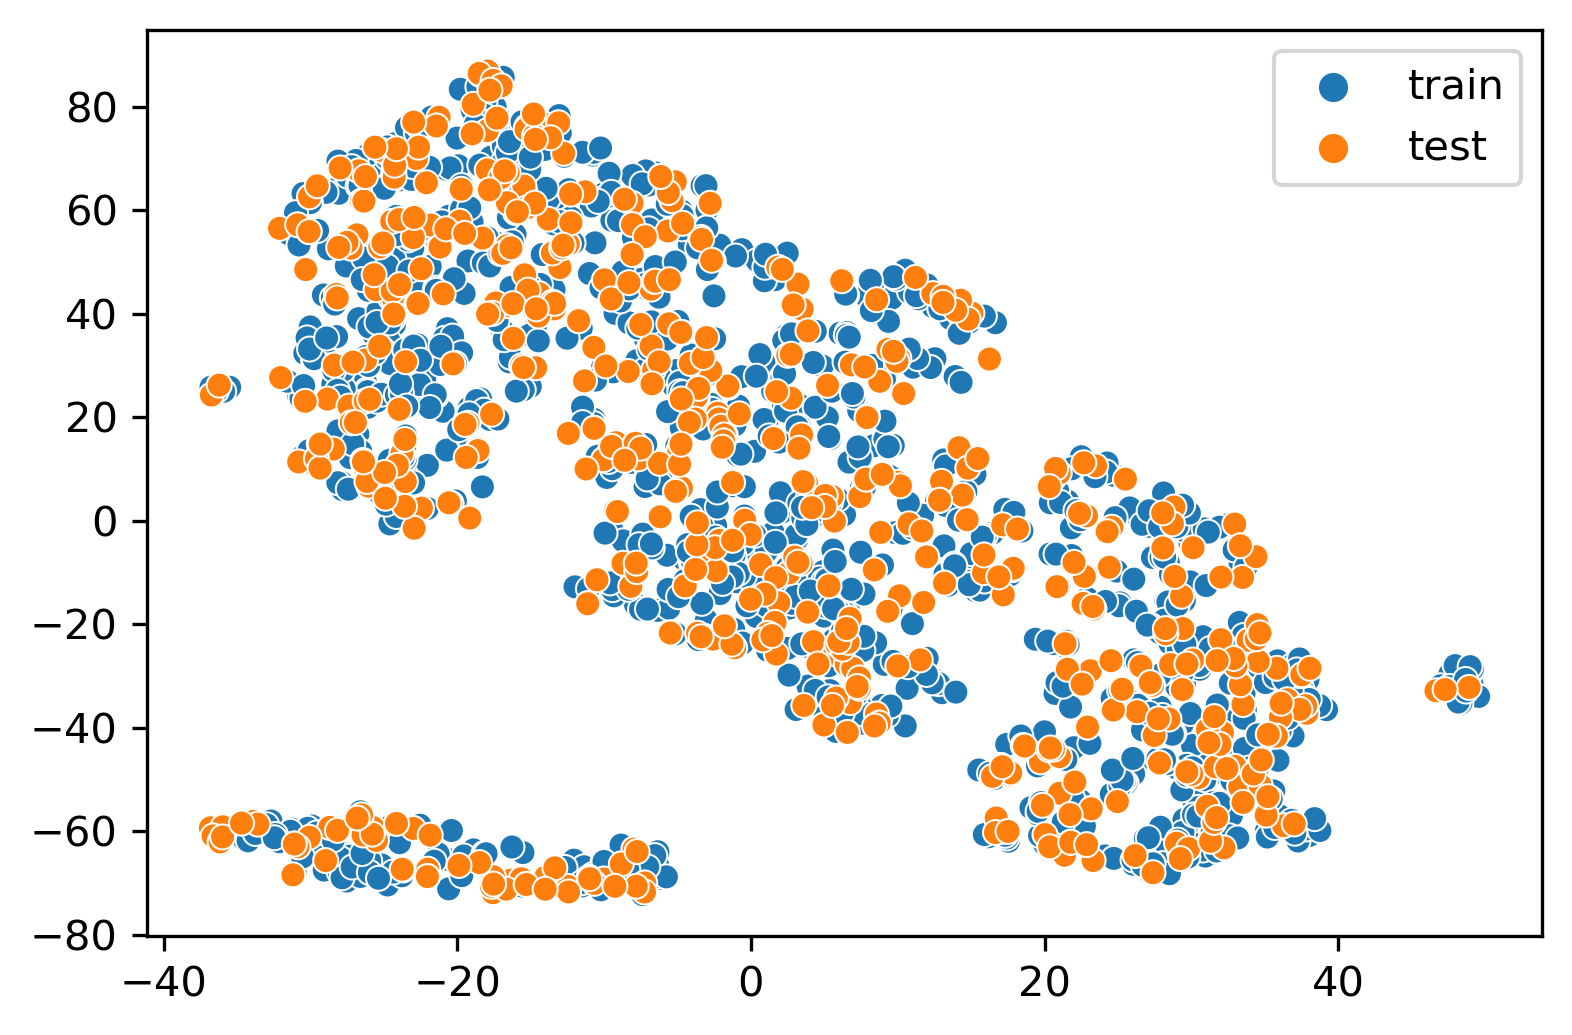

In [9]:
data_RDKit = np.concatenate((train_dataset.X, test_dataset.X), axis=0)

# 运行t-SNE算法
tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(data_RDKit)

# 绘制结果
sns.scatterplot(x=transformed_data[:, 0], y=transformed_data[:, 1], hue=['train']*1336 + ['test']*573)

# GridSearchCV

In [10]:
scoring = {
          'F1':make_scorer(f1_score),
          'AUC':make_scorer(roc_auc_score),
           'BA':make_scorer(balanced_accuracy_score),
           'MCC':make_scorer(matthews_corrcoef)
}

rf_param_grid = {'n_estimators':[50,100,150,200,250,300,350,400],
              'max_depth':[20,30,40,50,60,70,80,90,100,110],
            'max_features':["auto", "sqrt", "log2"]}
    
    
rf_classifier = RandomForestClassifier()

cv = KFold(n_splits=5, shuffle=True, random_state=100)


rf_gs = GridSearchCV(
                    rf_classifier,
                   rf_param_grid,
                 scoring = scoring,
                  cv = cv,
                 n_jobs = -1,
               refit = 'F1',
           return_train_score = True)

rf_gs_fit = rf_gs.fit(train_dataset.X, train_dataset.y.ravel())

In [11]:
val_F1 = rf_gs.best_score_
val_AUC = rf_gs.cv_results_['mean_test_AUC'][rf_gs.best_index_]
val_BA = rf_gs.cv_results_['mean_test_BA'][rf_gs.best_index_]
val_MCC = rf_gs.cv_results_['mean_test_MCC'][rf_gs.best_index_]

# GridSearchCV_Result

In [12]:
print('Best parameters: ', rf_gs.best_params_)
print('Best score (F1): ', rf_gs.best_score_)
print('AUC: ', rf_gs.cv_results_['mean_test_AUC'][rf_gs.best_index_])
print('BA: ', rf_gs.cv_results_['mean_test_BA'][rf_gs.best_index_])
print('MCC: ',rf_gs.cv_results_['mean_test_MCC'][rf_gs.best_index_])

Best parameters:  {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 400}
Best score (F1):  0.850643555790733
AUC:  0.8707714449927444
BA:  0.8707714449927444
MCC:  0.7468502438720398


In [13]:
rf_model = rf_gs_fit.best_estimator_
rf_model

RandomForestClassifier(max_depth=30, n_estimators=400)

# Evaluate model

In [14]:
y_test_pred_proba = rf_model.predict_proba(test_dataset.X)
y_test_pred = rf_model.predict(test_dataset.X)

In [15]:
tn, fp, fn, tp = confusion_matrix(test_dataset.y, y_test_pred).ravel()
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)
print('TP:', tp)

TN: 284
FP: 29
FN: 48
TP: 212


In [16]:
rf_test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    rf_test_pred_list.append(test_score)

In [17]:
rf_test_pred_array = np.array(rf_test_pred_list)

In [18]:
test_F1 = f1_score(test_dataset.y,np.round(rf_test_pred_array))
test_AUC = roc_auc_score(test_dataset.y,rf_test_pred_list)
test_BA =  balanced_accuracy_score(test_dataset.y,np.round(rf_test_pred_array))
test_MCC = matthews_corrcoef(test_dataset.y,np.round(rf_test_pred_array))

# Finall result

In [19]:
rf_performance_dataset = {
    'F1':[val_F1,test_F1],
    'AUC':[val_AUC,test_AUC],
    'BA':[val_BA,test_BA],
    'MCC':[val_MCC,test_MCC],
}

In [21]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,F1,AUC,BA,MCC
val,0.850644,0.870771,0.870771,0.746850
test,0.846307,0.917627,0.861366,0.728885
